### Want to see: In a good unit, what does trial-by-trial difference look like in intertrial interval?

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d

warnings.filterwarnings('ignore')

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [4]:
positions = spike_utils.get_unit_positions(sessions)

In [5]:
model = "Linear"
mode = "ZFiringRate"

def get_agg_glm_res(session):
    # res_name = f"{session}_glm_{fb_type}_residual_fr_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    res_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_values_agg.pickle"
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID
    return res
glm_res = pd.concat(sessions.apply(lambda x: get_agg_glm_res(x.session_name), axis=1).values)

In [6]:
merged = pd.merge(glm_res, positions, on=["PseudoUnitID", "session", "UnitID"])

In [8]:
top_5 = merged.sort_values(by="score", ascending=False)[:5]

In [32]:
def look_at_fr_diff(row):
    num_bins = 10
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins)
    beh = behavioral_utils.calc_feature_probs(beh)
    beh = behavioral_utils.calc_feature_value_entropy(beh)

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    agg["PrevFiringRate"] = agg.FiringRate.shift()
    agg = agg.dropna()
    agg["FiringRateDiff"] = agg.FiringRate - agg.PrevFiringRate
    merged = pd.merge(agg, beh, on="TrialNumber")

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    ax = axs[0]
    visualization_utils.plot_mean_sterrs_by_bin(merged, "FiringRate", "BlockPositionBin", ax, row.PseudoUnitID, num_bins)
    ax = axs[1]
    visualization_utils.plot_mean_sterrs_by_bin(merged, "FiringRateDiff", "BlockPositionBin", ax, row.PseudoUnitID, num_bins)

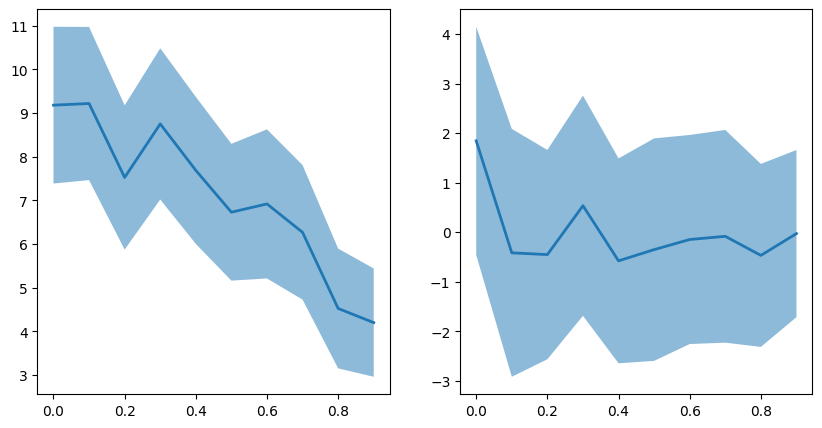

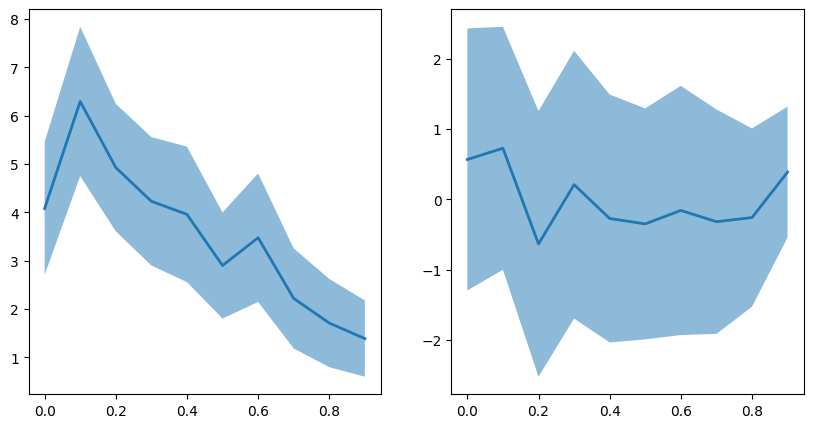

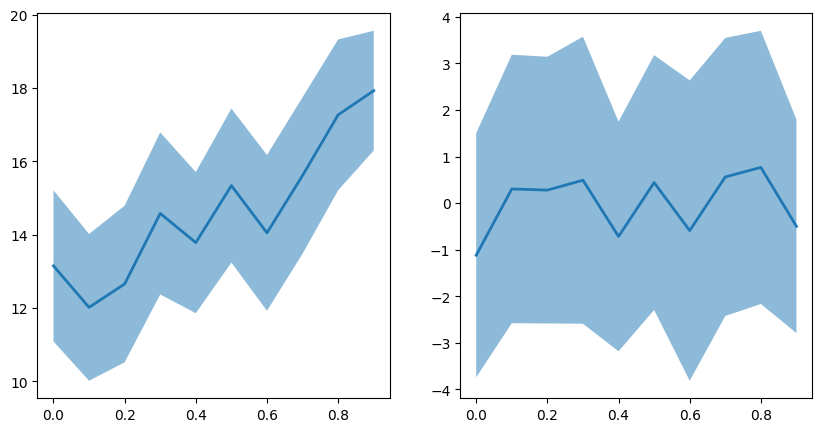

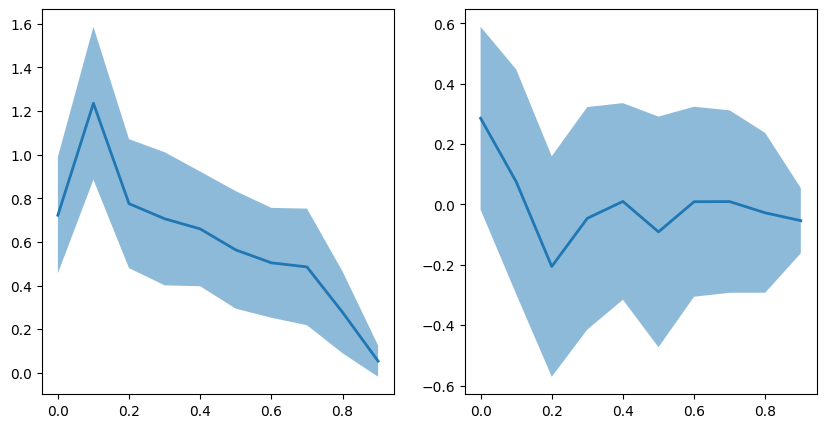

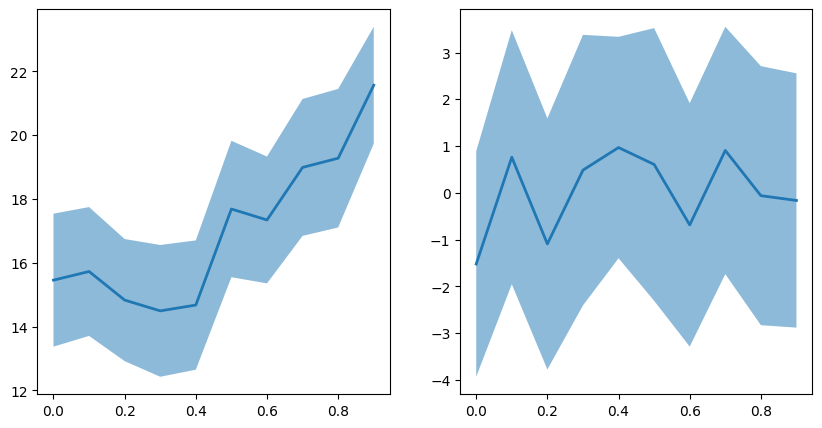

In [33]:
for i, row in top_5.iterrows():
    look_at_fr_diff(row)